## Imports

In [174]:
# MATLAB code from https://github.com/briandaniel/KroghCylinderModel
# Brian Hong 6-19-19
# File determines the equations of the Krogh cylinder model of oxygen
# transport used in Mcguire, Secomb (2001)

# Adapted to Python by Emma Bluemke 2021

# This import registers the 3D projection, but is otherwise unused.

from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline
import numpy as np
import scipy
import math
from scipy import integrate

## Parameters 
(Formerly called "KroghParams.m")

In [175]:
# param = value % Units | Description
Pb = 100; # Torr | Average partial pressure of oxygen in blood at capillary entrance 
P50 = 26; # Torr | Half-maximal hemoglobin saturation
n = 2.7; # - | Hill equation exponent
Cb = 0.2; # cm^3 O_2/cm^3 blood | Oxygen carrying capacity of blood
Sh = 2.5; # - | Sherwood number
Kpl = 8.3e-10; # (cm^2/s)[cm^3 O_2 /(cm^3*Torr)] | Krogh diffusion constant in plasma

# prm.Vbar = 2.25; # mm/s | Average blood flow
Vbar = 2.25e-1; # cm/s | Average blood flow
# prm.Vbar = 3.49e-1; # cm/s | Average blood flow
K = 9.4e-10; # (cm^2/s)[cm^3 O_2 /(cm^3*Torr)] | Krogh diffusion constant in tissue

# NOTE: In the text [M0] are is listed as cm^3 *100 cm^3/min, but should be
# listed as cm^3/(100 cm^3 * min )
# prm.M0 = 40; % cm^3 O_2 (100 cm^3*min) | Oxygen demand 
M0 = 40/6000; # cm^3 O_2 / ( cm^3*s ) | Oxygen demand

P0 = 1; # Torr | Half-maximal oxygen consumption
Dmb = 1.73e-7; # cm^2/s | Myoglobin diffusion coefficient
Cmb = 3.83e-7; # mol/cm^3 | Concentration of myoglobin
P50mb = 3.2; # Torr | Pressure where myoglobin 50% saturated with Oxygen

Vm = 2.24e4; # cm^3 | Molar volume
Mt = 6.52e-9;# (cm^2/s)[cm^3 O_2 /(cm^3*Torr)] | Mass transfer coef

# From the text
#Rc = 2.5; # microns | Capillary radius
#L = 0.5; # mm | Capillary length
#Rt = 26; # microns | Tissue Cylinder radius

# Converted to consistent units
Rc = 2.5e-4; # cm | Capillary radius
L = 0.5e-1; # cm | Capillary length
Rt = 26e-4; # cm| Tissue Cylinder radius


# Numerical params
Nz = 500;
Nr = 500;


## Internal functions 
These seem to work fine in python now

In [176]:
def guess(r):
    g =(1+r*0, 0*r); # guessing that everything is 0 and 1
    return(g)

def diffusionODE_BC(Ya,Yb):
    P_Rc = Ya[0]
    dPdr_Rc = Ya[1] # pressure at this initial boundary is the more complicated condition
    
    dPdr_Rt = Yb[1] # pressure at the boundary is 0
    
    res1 = 2*math.pi*Rc*K*dPdr_Rc + Mt*(Pb-P_Rc) # condition inside capillary 
    res2 = dPdr_Rt;
    
    res = (res1,res2)
    return(res)

def diffusionODE(r,Y):
    #NOTE: Y(1) = P, Y(2) = u, where u is the aux variable u = P'
    P = Y[0];
    u = Y[1];
     # Brian - why is this here?? Scared to remove - will it break things?
     
    # Oxygen consumption rate (per unit volume)
    MP = M0*(P/(P0+P));

    # In this case the derivatve is directly evaluated
    dudr = -u/r + 1/K*MP;
    dPdr = u;
    
    dY = (dPdr,dudr);
    return(dY)

## ODE part - This is the part I have questions about - replacing the MATLAB functions
I think solve_bvp from scipy will be able to be used here, but I'm not sure? https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html

In [177]:
z = np.linspace(0,L,Nz)
r_tissue = np.linspace(Rc,Rt,Nr)

Psltn = np.zeros((Nr,Nz))


for k in range(0,Nz):
    if k>0: ### this loop works fine
        # compute the integral
        MP = M0*(P/(P0+P))
        q = 2*math.pi*np.trapz(r,MP*r)
        Shbi = (Pb/P50)**n/(1+(Pb/P50)**n)
        Ci = Cb*Shbi;
        dz = z[k]-z[k-1]
        volFlowRate = Vbar*math.pi*Rc**2
        Ciplus1 = Ci-dz*(q/volFlowRate)      
        Pb = P50*(Ciplus1/(Cb - Ciplus1))**(1/n) 

   # solinit = bvpinit(r_tissue, @guess );
    ### need to replace
    #solinit = bvpinit(x,yinit) uses the initial mesh x and initial solution guess yinit 
    #to form an initial guess of the solution for a boundary value problem. You then can 
    #use the initial guess solinit as one of the inputs to bvp4c or bvp5c to solve the 
    #boundary value problem.
    
    # so I think I need https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html???

    #odeFunc = @(r,Y) diffusionODE(r,Y,P0,M0,K); # ### need to replace - output is dY = (dPdr,dudr); 
    #bcFunc = @(ya,yb) diffusionODE_BC(Ya,Yb,Pb,K,Rc); # ### need to replace - output is res = (res1,res2);

    # x and y are the independent variable and y is the dependent
    # "y" in the python function input is the initial guesses which is solinit here 
    # r is the independent and Y contains two elements, u and P which are dependent variables that you're solving for 
    #sol = bvp4c(odeFunc, bcFunc, solinit); ### need to replace
    
    init_y=guess(r_tissue)
    
    solution=scipy.integrate.solve_bvp(diffusionODE, diffusionODE_BC, r_tissue, init_y, verbose=2)
    #sol = bvp4c(odefun,bcfun,solinit) integrates a system of differential equations 
    #of the form y′ = f(x,y) specified by odefun, subject to the boundary conditions 
    #described by bcfun and the initial solution guess solinit. Use the bvpinit function 
    #to create the initial guess solinit, which also defines the points at which the 
    #boundary conditions in bcfun are enforced.

    #P = interp1(sol.x,sol.y(0,:),r_tissue ); ### need to replace
    #vq = interp1(x,v,xq) returns interpolated values of a 1-D function at 
    #specific query points using linear interpolation. Vector x contains 
    #the sample points, and v contains the corresponding values, v(x). 
    #Vector xq contains the coordinates of the query points.
    
    r = r_tissue;
    
    r_plot = np.linspace(Rc,Rt,Nr)
    y_plot = solution.sol(r_plot)[0]
    
    P=y_plot;
    
    Psltn[:,k] = P; # array of nr by nz here, the p here is the value along the grid that you're computing from your solution

    #print('Solving step k = ', str(k), '/', str(Nz))



   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          3.33e-02       1.75e-16          500            303      
       2          2.35e-05       1.85e-14          803             0       
Solved in 2 iterations, number of nodes 803. 
Maximum relative residual: 2.35e-05 
Maximum boundary residual: 1.85e-14
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          3.59e-02       5.45e-16          500            305      
       2          3.22e-05       3.68e-15          805             0       
Solved in 2 iterations, number of nodes 805. 
Maximum relative residual: 3.22e-05 
Maximum boundary residual: 3.68e-15
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          3.84e-02       5.25e-16          500            307      
       2          9.17e-07       8.03e-18          807             0       
Solved in 2 iterations, number of nodes 807. 
Maximum relative residual: 9.17e

       1          2.91e-02       7.72e-17          500            264      
       2          1.69e-05       2.60e-18          764             0       
Solved in 2 iterations, number of nodes 764. 
Maximum relative residual: 1.69e-05 
Maximum boundary residual: 2.60e-18
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.79e-02       5.72e-17          500            261      
       2          1.62e-05       2.39e-18          761             0       
Solved in 2 iterations, number of nodes 761. 
Maximum relative residual: 1.62e-05 
Maximum boundary residual: 2.39e-18
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          5.56e-02       2.41e-16          500            295      
       2          1.14e-05       2.63e-19          795             0       
Solved in 2 iterations, number of nodes 795. 
Maximum relative residual: 1.14e-05 
Maximum boundary residual: 2.63e-19
   Iteration    Max residual  Max B

       1          2.51e-02       3.26e-13          500            473      
       2          9.94e-06       3.79e-20          973             0       
Solved in 2 iterations, number of nodes 973. 
Maximum relative residual: 9.94e-06 
Maximum boundary residual: 3.79e-20
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.41e-02       3.19e-13          500            473      
       2          8.67e-06       1.18e-19          973             0       
Solved in 2 iterations, number of nodes 973. 
Maximum relative residual: 8.67e-06 
Maximum boundary residual: 1.18e-19
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.32e-02       3.13e-13          500            472      
       2          7.56e-06       5.50e-20          972             0       
Solved in 2 iterations, number of nodes 972. 
Maximum relative residual: 7.56e-06 
Maximum boundary residual: 5.50e-20
   Iteration    Max residual  Max B

       2          3.36e-05       1.39e-20          953             0       
Solved in 2 iterations, number of nodes 953. 
Maximum relative residual: 3.36e-05 
Maximum boundary residual: 1.39e-20
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          9.01e-03       1.64e-13          500            453      
       2          3.15e-05       1.15e-20          953             0       
Solved in 2 iterations, number of nodes 953. 
Maximum relative residual: 3.15e-05 
Maximum boundary residual: 1.15e-20
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          8.86e-03       1.62e-13          500            452      
       2          2.96e-05       1.72e-20          952             0       
Solved in 2 iterations, number of nodes 952. 
Maximum relative residual: 2.96e-05 
Maximum boundary residual: 1.72e-20
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          8.71e-03       1.

       2          3.26e-06       2.94e-21          888             0       
Solved in 2 iterations, number of nodes 888. 
Maximum relative residual: 3.26e-06 
Maximum boundary residual: 2.94e-21
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          4.93e-03       1.03e-13          500            386      
       2          3.13e-06       5.03e-22          886             0       
Solved in 2 iterations, number of nodes 886. 
Maximum relative residual: 3.13e-06 
Maximum boundary residual: 5.03e-22
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          4.88e-03       1.02e-13          500            384      
       2          3.00e-06       1.32e-22          884             0       
Solved in 2 iterations, number of nodes 884. 
Maximum relative residual: 3.00e-06 
Maximum boundary residual: 1.32e-22
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          4.83e-03       1.

       1          3.33e-03       7.49e-14          500            321      
       2          1.05e-06       7.94e-22          821             0       
Solved in 2 iterations, number of nodes 821. 
Maximum relative residual: 1.05e-06 
Maximum boundary residual: 7.94e-22
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          3.30e-03       7.45e-14          500            320      
       2          1.04e-06       1.03e-21          820             0       
Solved in 2 iterations, number of nodes 820. 
Maximum relative residual: 1.04e-06 
Maximum boundary residual: 1.03e-21
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          3.28e-03       7.40e-14          500            318      
       2          1.04e-06       4.50e-22          818             0       
Solved in 2 iterations, number of nodes 818. 
Maximum relative residual: 1.04e-06 
Maximum boundary residual: 4.50e-22
   Iteration    Max residual  Max B

       1          2.48e-03       5.87e-14          500            303      
       2          1.98e-05       2.33e-19          803             0       
Solved in 2 iterations, number of nodes 803. 
Maximum relative residual: 1.98e-05 
Maximum boundary residual: 2.33e-19
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.47e-03       5.85e-14          500            302      
       2          1.95e-05       1.94e-19          802             0       
Solved in 2 iterations, number of nodes 802. 
Maximum relative residual: 1.95e-05 
Maximum boundary residual: 1.94e-19
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.45e-03       5.82e-14          500            302      
       2          1.92e-05       2.48e-19          802             0       
Solved in 2 iterations, number of nodes 802. 
Maximum relative residual: 1.92e-05 
Maximum boundary residual: 2.48e-19
   Iteration    Max residual  Max B

       1          2.20e-03       5.32e-14          500            289      
       2          1.39e-05       2.76e-19          789             0       
Solved in 2 iterations, number of nodes 789. 
Maximum relative residual: 1.39e-05 
Maximum boundary residual: 2.76e-19
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.19e-03       5.29e-14          500            289      
       2          1.38e-05       3.82e-19          789             0       
Solved in 2 iterations, number of nodes 789. 
Maximum relative residual: 1.38e-05 
Maximum boundary residual: 3.82e-19
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          2.18e-03       5.27e-14          500            288      
       2          1.36e-05       3.22e-19          788             0       
Solved in 2 iterations, number of nodes 788. 
Maximum relative residual: 1.36e-05 
Maximum boundary residual: 3.22e-19
   Iteration    Max residual  Max B

       1          1.99e-03       4.87e-14          500            274      
       2          1.02e-05       1.55e-19          774             0       
Solved in 2 iterations, number of nodes 774. 
Maximum relative residual: 1.02e-05 
Maximum boundary residual: 1.55e-19
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.98e-03       4.85e-14          500            274      
       2          1.01e-05       2.68e-19          774             0       
Solved in 2 iterations, number of nodes 774. 
Maximum relative residual: 1.01e-05 
Maximum boundary residual: 2.68e-19
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.97e-03       4.84e-14          500            274      
       2          9.99e-06       4.18e-19          774             0       
Solved in 2 iterations, number of nodes 774. 
Maximum relative residual: 9.99e-06 
Maximum boundary residual: 4.18e-19
   Iteration    Max residual  Max B

       1          1.82e-03       4.51e-14          500            260      
       2          7.77e-06       2.57e-19          760             0       
Solved in 2 iterations, number of nodes 760. 
Maximum relative residual: 7.77e-06 
Maximum boundary residual: 2.57e-19
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.81e-03       4.49e-14          500            259      
       2          7.69e-06       1.45e-19          759             0       
Solved in 2 iterations, number of nodes 759. 
Maximum relative residual: 7.69e-06 
Maximum boundary residual: 1.45e-19
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.80e-03       4.48e-14          500            258      
       2          7.61e-06       1.92e-19          758             0       
Solved in 2 iterations, number of nodes 758. 
Maximum relative residual: 7.61e-06 
Maximum boundary residual: 1.92e-19
   Iteration    Max residual  Max B

       1          1.68e-03       4.21e-14          500            246      
       2          6.07e-06       7.37e-20          746             0       
Solved in 2 iterations, number of nodes 746. 
Maximum relative residual: 6.07e-06 
Maximum boundary residual: 7.37e-20
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.67e-03       4.20e-14          500            244      
       2          6.01e-06       5.33e-20          744             0       
Solved in 2 iterations, number of nodes 744. 
Maximum relative residual: 6.01e-06 
Maximum boundary residual: 5.33e-20
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.67e-03       4.19e-14          500            244      
       2          5.95e-06       1.76e-20          744             0       
Solved in 2 iterations, number of nodes 744. 
Maximum relative residual: 5.95e-06 
Maximum boundary residual: 1.76e-20
   Iteration    Max residual  Max B

       1          1.56e-03       3.96e-14          500            231      
       2          4.84e-06       1.52e-19          731             0       
Solved in 2 iterations, number of nodes 731. 
Maximum relative residual: 4.84e-06 
Maximum boundary residual: 1.52e-19
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.56e-03       3.95e-14          500            231      
       2          4.80e-06       1.24e-19          731             0       
Solved in 2 iterations, number of nodes 731. 
Maximum relative residual: 4.80e-06 
Maximum boundary residual: 1.24e-19
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.55e-03       3.94e-14          500            231      
       2          4.75e-06       3.46e-20          731             0       
Solved in 2 iterations, number of nodes 731. 
Maximum relative residual: 4.75e-06 
Maximum boundary residual: 3.46e-20
   Iteration    Max residual  Max B

       1          1.47e-03       3.74e-14          500            219      
       2          3.92e-06       1.34e-19          719             0       
Solved in 2 iterations, number of nodes 719. 
Maximum relative residual: 3.92e-06 
Maximum boundary residual: 1.34e-19
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.46e-03       3.73e-14          500            218      
       2          3.89e-06       2.26e-19          718             0       
Solved in 2 iterations, number of nodes 718. 
Maximum relative residual: 3.89e-06 
Maximum boundary residual: 2.26e-19
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.46e-03       3.72e-14          500            218      
       2          3.85e-06       6.22e-20          718             0       
Solved in 2 iterations, number of nodes 718. 
Maximum relative residual: 3.85e-06 
Maximum boundary residual: 6.22e-20
   Iteration    Max residual  Max B

       2          3.21e-06       1.54e-19          707             0       
Solved in 2 iterations, number of nodes 707. 
Maximum relative residual: 3.21e-06 
Maximum boundary residual: 1.54e-19
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.38e-03       3.55e-14          500            207      
       2          3.19e-06       3.53e-19          707             0       
Solved in 2 iterations, number of nodes 707. 
Maximum relative residual: 3.19e-06 
Maximum boundary residual: 3.53e-19
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.38e-03       3.54e-14          500            207      
       2          3.16e-06       1.97e-19          707             0       
Solved in 2 iterations, number of nodes 707. 
Maximum relative residual: 3.16e-06 
Maximum boundary residual: 1.97e-19
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.38e-03       3.

       1          1.34e-03       3.39e-14          500            197      
       2          2.63e-06       2.55e-19          697             0       
Solved in 2 iterations, number of nodes 697. 
Maximum relative residual: 2.63e-06 
Maximum boundary residual: 2.55e-19
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.34e-03       3.38e-14          500            196      
       2          2.61e-06       1.07e-19          696             0       
Solved in 2 iterations, number of nodes 696. 
Maximum relative residual: 2.61e-06 
Maximum boundary residual: 1.07e-19
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.34e-03       3.38e-14          500            195      
       2          2.59e-06       2.85e-20          695             0       
Solved in 2 iterations, number of nodes 695. 
Maximum relative residual: 2.59e-06 
Maximum boundary residual: 2.85e-20
   Iteration    Max residual  Max B

       2          1.94e-06       1.56e-21          682             0       
Solved in 2 iterations, number of nodes 682. 
Maximum relative residual: 1.94e-06 
Maximum boundary residual: 1.56e-21
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.43e-03       3.17e-14          500            181      
       2          1.92e-06       7.26e-20          681             0       
Solved in 2 iterations, number of nodes 681. 
Maximum relative residual: 1.92e-06 
Maximum boundary residual: 7.26e-20
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.43e-03       3.16e-14          500            180      
       2          1.91e-06       8.04e-20          680             0       
Solved in 2 iterations, number of nodes 680. 
Maximum relative residual: 1.91e-06 
Maximum boundary residual: 8.04e-20
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.44e-03       3.

## The 3D surf plot

In [178]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('cool')
new_cmap = truncate_colormap(cmap, 0.2, 1)


# Make data.
X = np.linspace(Rc,Rt,Nr)
Y = np.linspace(0, L, Nz)
X, Y = np.meshgrid(X, Y)
Z=Psltn

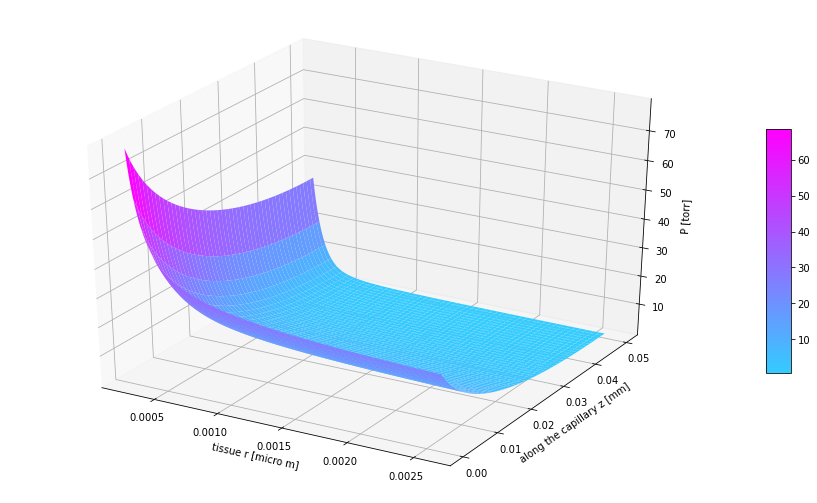

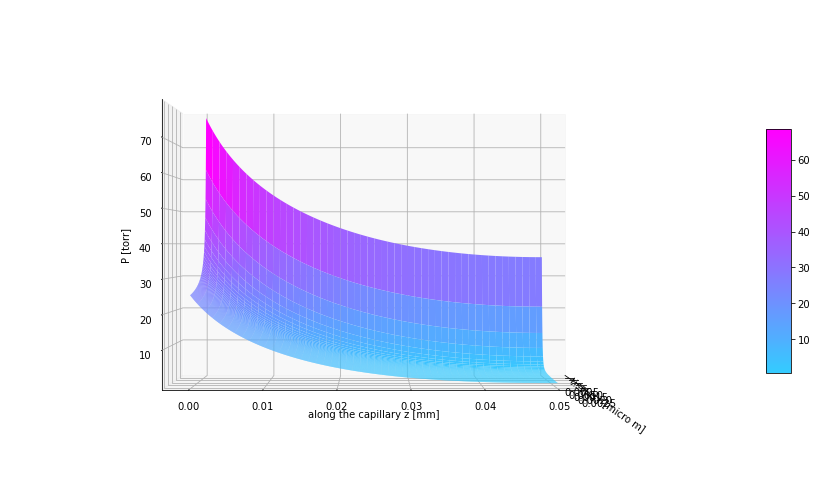

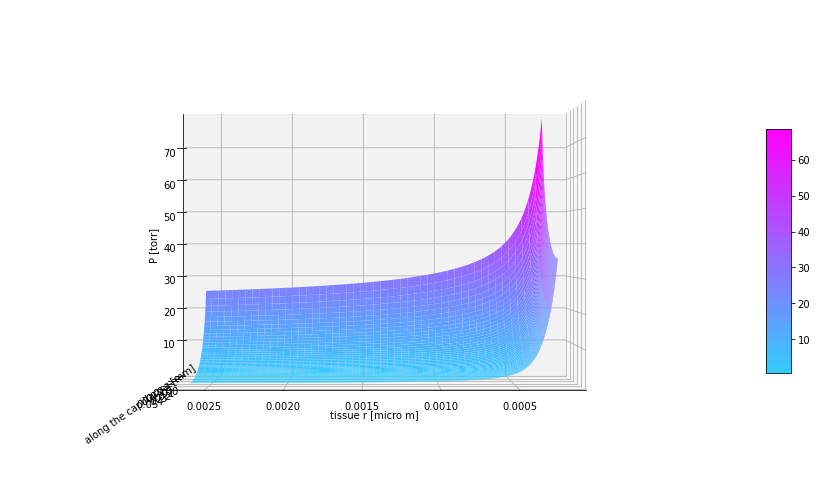

In [180]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = [16,9]
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X,Y, Z, cmap=new_cmap,
                       linewidth=1)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

ax.set_ylabel('along the capillary z [mm]')
ax.set_xlabel('tissue r [micro m]')
ax.set_zlabel('P [torr]')

plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
plt.rcParams["figure.figsize"] = [16,9]

surf = ax.plot_surface(X,Y, Z, cmap=new_cmap,
                       linewidth=0.1)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

ax.set_ylabel('along the capillary z [mm]')
ax.set_xlabel('tissue r [micro m]')
ax.set_zlabel('P [torr]')
ax.view_init(0, 0)

plt.show()


fig = plt.figure()
plt.rcParams["figure.figsize"] = [16,9]
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X,Y, Z, cmap=new_cmap,
                       linewidth=1)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

ax.set_ylabel('along the capillary z [mm]')
ax.set_xlabel('tissue r [micro m]')
ax.set_zlabel('P [torr]')
ax.view_init(0,90)

plt.show()


## 2D Plots

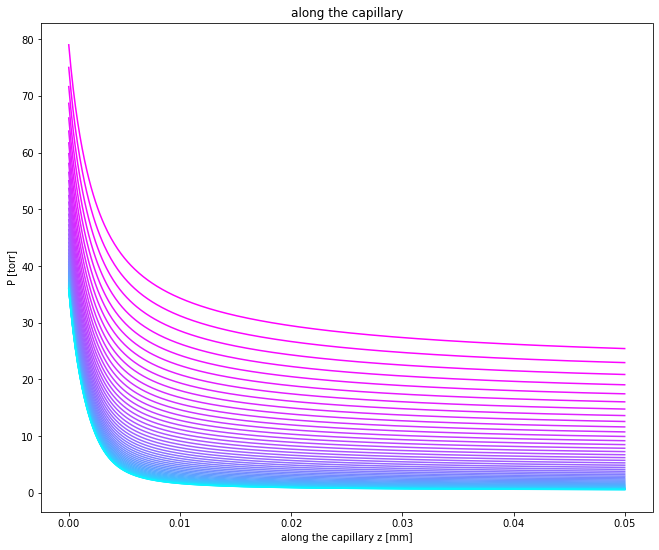

In [181]:
X = np.linspace(Rc,Rt,Nr)
Y = np.linspace(0, L, Nz)

fig = plt.figure()
ax = fig.add_subplot(111)
            
for i in range(0,len(Z),10):
    plt.plot(Y,Z[i])


colormap = plt.cm.cool_r #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0,0.95,len(ax.lines))]
for i,j in enumerate(ax.lines):
    j.set_color(colors[i])
ax.set_aspect(0.8/ax.get_data_ratio(), adjustable='box')

plt.title(str('along the capillary'))
plt.xlabel('along the capillary z [mm]')
plt.ylabel('P [torr]')
plt.show()

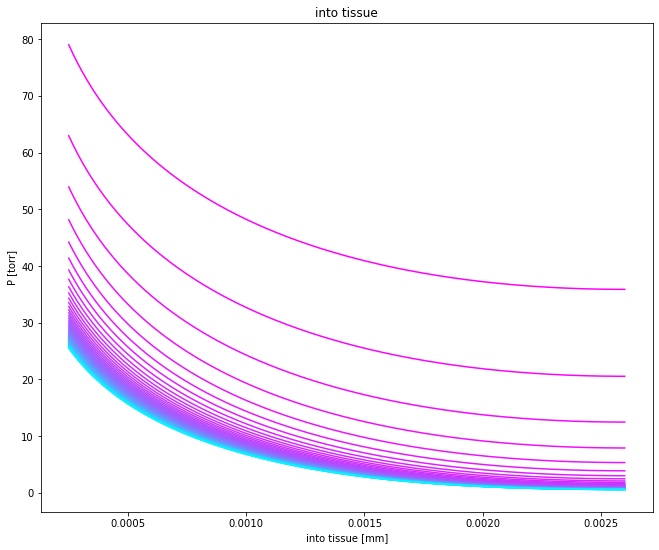

In [182]:
fig = plt.figure()
ax = fig.add_subplot(111)
            
for i in range(0,len(Z),10):
    plt.plot(X,Z[:,i])

colormap = plt.cm.cool_r #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0,0.95,len(ax.lines))]
for i,j in enumerate(ax.lines):
    j.set_color(colors[i])
ax.set_aspect(0.8/ax.get_data_ratio(), adjustable='box')

plt.title(str('into tissue'))
plt.xlabel('into tissue [mm]')
plt.ylabel('P [torr]')
plt.show()